In [1]:
import pyarrow.parquet as pq
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

In [2]:
t = pq.read_table('fuller_data.parquet')

In [3]:
df = t.to_pandas()
df.drop(['id', 'naid', 'birth date', 'birth_date', 'alias', 'father', 'mother', 'father\'s name', 'mother\'s name', 'sex', ''], axis=1, inplace=True)
df = df[df['naturalization date'] > np.datetime64("1940-01-01")]
df = df[df['naturalization date'] < np.datetime64("1944-12-31")]
df['naturalization date'] = df['naturalization date'].apply(lambda x: x.date())
df.sort_values(by='anum', inplace=True)
df = df[df.anum<=df.anum.quantile(0.95)]
df = df[df['anum'] > 0]
df['naturalization location'] = df['naturalization location'].apply(lambda s: s.lower().strip().split(',')[0].strip())
df['port of entry'] = df['port of entry'].apply(lambda s: s.lower().strip().split(',')[0].strip())
ndf = df.to_numpy()
df.reset_index(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    355 non-null    int64         
 1   country                  355 non-null    object        
 2   port of entry            355 non-null    object        
 3   date of entry            156 non-null    datetime64[ns]
 4   name                     355 non-null    object        
 5   naturalization date      355 non-null    object        
 6   naturalization location  355 non-null    object        
 7   anum                     355 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 22.3+ KB


In [5]:
anums = df['anum']
x = np.arange(len(anums))
y = anums.to_numpy()

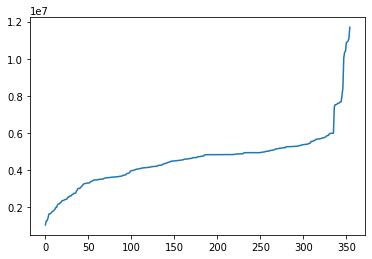

In [6]:
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

In [7]:
# Creating Graph
G = nx.Graph()

_last_anum = 0
for index, row in enumerate(ndf):
    nat_loc, anum = row[5], row[6]
    nat_loc = nat_loc.lower().strip().split(',')[0].strip()
    if not isinstance(anum, int) or anum < 0:
        continue
    if np.abs(anum - _last_anum) < 100:
        G.add_edge(_last_anum, anum, weight=1)
    if nat_loc != '':
        G.add_edge(anum, nat_loc, weight=0.1)
    _last_anum = anum
    

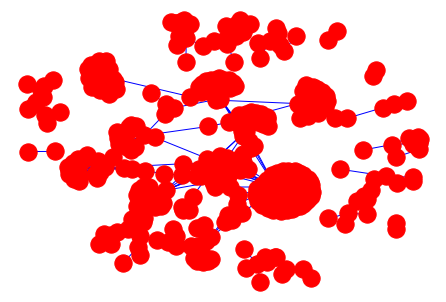

In [8]:
nx.draw(G, node_color='r', edge_color='b')

In [9]:
from networkx.algorithms import community

communities_generator = community.greedy_modularity_communities(G, 'weight')
for c in communities_generator:
    if len(c) < 5: continue
    print(list(sorted(c, key=lambda x: x if isinstance(x, int) else -1)))

['st. paul', 'new york', 1036057, 1621631, 1974590, 2236053, 2386002, 2685015, 2847330, 3154983, 3292058, 3381543, 3459245, 3465367, 3490859, 3586602, 3956883, 3970258, 3979881, 3985228, 4007813, 4026340, 4083609, 4118164, 4118210, 4122397, 4184733, 4186818, 4189244, 4240420, 4258042, 4279252, 4325615, 4366130, 4408291, 4418508, 4491241, 4496975, 4501282, 4508755, 4536120, 4594099, 4620668, 4627531, 4717406, 4736993, 4811302, 4816879, 4819951, 4827147, 4829604, 4829642, 4829791, 4829860, 4829901, 4829929, 4830500, 4840351, 4845343, 4850842, 4864982, 4866216, 4867371, 4868069, 4881810, 4932889, 4932909, 4932917, 4932928, 4933162, 4943585, 4962693, 4974916, 5007220, 5044527, 5078750, 5134876, 5253089, 5310595, 5312585, 5329581, 5363791, 5371583, 5427008, 5427504, 5538851, 5538860, 5617984, 5678348, 5717424, 5784074, 5937322, 5984661, 7520346, 7545168]
['tampa', 'san francisco', 'chicago', 'miami', 'philadelhia', 1708343, 1747879, 2404094, 2528023, 2604140, 3005151, 3294623, 3294800, 3469

In [10]:
for i in nx.connected_components(G):
    print(list(sorted(i, key=lambda x: x if isinstance(x, int) else -1)))

['hartford', 'san francisco', 'philadelhia', 'boston', 'detroit', 'newark', 'st. paul', 'chicago', 'phoenix', 'new york', 'louisville', 'tampa', 'washington', 'cleveland', 'miami', 'los angeles', 1036057, 1247938, 1266114, 1405086, 1621631, 1638033, 1645490, 1708343, 1747879, 1784735, 1826273, 1974590, 1980303, 2164784, 2236053, 2324912, 2349558, 2386002, 2404094, 2418191, 2523227, 2528023, 2586229, 2604140, 2672850, 2685015, 2733797, 2847330, 2919740, 3004573, 3005151, 3154983, 3257244, 3266472, 3274967, 3292058, 3294623, 3294800, 3300698, 3341973, 3381543, 3449761, 3458037, 3459245, 3465367, 3469603, 3469695, 3490859, 3493428, 3509640, 3509666, 3544637, 3554913, 3565839, 3586602, 3587729, 3590791, 3591196, 3602247, 3609303, 3619160, 3633905, 3634776, 3639268, 3656860, 3659645, 3665236, 3672974, 3716741, 3729639, 3730328, 3807003, 3821130, 3857095, 3948664, 3956883, 3970258, 3979881, 3985228, 4007813, 4026340, 4043557, 4045590, 4058726, 4083609, 4084172, 4084239, 4112827, 4118164, 411

In [11]:
import pydgraph

schema = """
nat_loc: [uid] @reverse .
people: [uid] @reverse .
next: [uid] @reverse .
name: string @index(exact, term) .
anum: int @index(int) .
nat_date: string @index(exact, term) .
nat_location: string @index(exact, term) .

type Person {
    name
    anum
    nat_date
    nat_location
}

type Location {
    name
    people
}

type Root {
    nat_loc
}
"""

In [12]:
stub = pydgraph.DgraphClientStub(f"localhost:{9080}")
dg = pydgraph.DgraphClient(stub)
dg

In [13]:
df.to_json('filtered_data.json', orient='table')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    355 non-null    int64         
 1   country                  355 non-null    object        
 2   port of entry            355 non-null    object        
 3   date of entry            156 non-null    datetime64[ns]
 4   name                     355 non-null    object        
 5   naturalization date      355 non-null    object        
 6   naturalization location  355 non-null    object        
 7   anum                     355 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 22.3+ KB


In [14]:
dg.alter(pydgraph.Operation(drop_all=True))
dg.alter(pydgraph.Operation(schema=schema))

In [15]:
txn = dg.txn()

In [16]:
r = txn.mutate(set_obj={
    'uid': '_:root',
    'dgraph.type': 'Root',
})
root_uid = r.uids['root']

In [17]:
locs = dict()
people = dict()

_last_anum = 0
for index, row in enumerate(ndf):
    name, nat_loc, nat_date, anum = row[3], row[5], row[4], row[6]
    nat_loc = nat_loc.lower().strip().split(',')[0].strip()
    if not isinstance(anum, int) or anum <= 0:
        continue
    if nat_loc not in locs:
        r = txn.mutate(set_obj={
            'uid': '_:' + str(hash(nat_loc)),
            'dgraph.type': 'Location',
            'name': nat_loc,
        })
        uid = r.uids[str(hash(nat_loc))]
        locs[nat_loc] = uid
        
    r = txn.mutate(set_obj={
        'uid': '_:' + str(anum),
        'dgraph.type': 'Person',
        'name': name,
        'anum': anum,
        'nat_date': str(nat_date),
        'nat_location': nat_loc,
    })
    p_uid = r.uids[str(anum)]
    people[anum] = p_uid
    
    txn.mutate(set_obj={
        'uid': locs[nat_loc],
        'people': [{'uid': p_uid}]
    })

In [18]:
anums = list(sorted(people))
for index in range(len(anums)-1):
    txn.mutate(set_obj={
        'uid': people[anums[index]],
        'next': [{'uid': people[anums[index+1]]}]
    })

In [19]:
txn.mutate(set_obj={
    'uid': root_uid,
    'nat_loc': [
        {'uid': uid}
        for uid in locs.values()
    ]
})
None

In [20]:
txn.commit()
print('http://localhost:8000')

http://localhost:8000
